UAS: BIG DATA DAN DATA MINING

Nama: Yosua Aldrin Garanta

Nim: 23.11.5574

Kelas: IF-04



In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib

sns.set(style="whitegrid")


# --- CELL 2: LOAD DATA ---

In [2]:

# Mengambil dataset langsung dari URL (Mirror Github untuk stabilitas)
url = "https://raw.githubusercontent.com/martj42/international_results/master/results.csv"

print("Sedang mengunduh dataset...")
df = pd.read_csv(url)

print("Dataset Berhasil Dimuat!")
print(f"Total Baris Data Mentah: {df.shape[0]}")

Sedang mengunduh dataset...
Dataset Berhasil Dimuat!
Total Baris Data Mentah: 48943


# --- CELL 3: MEMAHAMI STRUKTUR DATA ---

In [3]:


print("--- 1. Info Tipe Data & Missing Values ---")
print(df.info())

print("\n--- 2. Contoh 5 Data Teratas ---")
display(df.head())

print("\n--- 3. Statistik Deskriptif (Untuk Kolom Angka) ---")
display(df.describe())

--- 1. Info Tipe Data & Missing Values ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48943 entries, 0 to 48942
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        48943 non-null  object
 1   home_team   48943 non-null  object
 2   away_team   48943 non-null  object
 3   home_score  48943 non-null  int64 
 4   away_score  48943 non-null  int64 
 5   tournament  48943 non-null  object
 6   city        48943 non-null  object
 7   country     48943 non-null  object
 8   neutral     48943 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 3.0+ MB
None

--- 2. Contoh 5 Data Teratas ---


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False



--- 3. Statistik Deskriptif (Untuk Kolom Angka) ---


,home_score,away_score
count,48943.000000,48943.000000
mean,1.756840,1.182294
std,1.771712,1.401307
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


# --- CELL 4: PREPROCESSING (FILTER & LABELING) ---

In [6]:

# 1. FILTERING WAKTU
# Alasan: Mengambil data era modern (2010 ke atas) agar relevan dengan kekuatan tim saat ini.
df['date'] = pd.to_datetime(df['date'])
df_clean = df[df['date'].dt.year >= 2010].copy().reset_index(drop=True)

# 2. MEMBUAT LABEL KELAS (TARGET VARIABLE)
# Alasan: Random Forest Classifier butuh kelas (0,1,2), bukan skor skor angka.
# Logika: 2 = Home Win, 1 = Draw, 0 = Away Win

def get_label(row):
    if row['home_score'] > row['away_score']:
        return 2 # Tuan Rumah Menang
    elif row['home_score'] == row['away_score']:
        return 1 # Seri
    else:
        return 0 # Tamu Menang

df_clean['match_result'] = df_clean.apply(get_label, axis=1)

print(f"Data setelah filter (>2010): {df_clean.shape[0]} baris")
print("Label Kelas 'match_result' berhasil dibuat.")
display(df_clean[['date', 'home_team', 'away_team', 'home_score', 'away_score', 'match_result']].head())

Data setelah filter (>2010): 15362 baris
Label Kelas 'match_result' berhasil dibuat.


,date,home_team,away_team,home_score,away_score,match_result
0,2010-01-02,Iran,North Korea,1,0,2
1,2010-01-02,Qatar,Mali,0,0,1
2,2010-01-02,Syria,Zimbabwe,6,0,2
3,2010-01-02,Yemen,Tajikistan,0,1,0
4,2010-01-03,Angola,Gambia,1,1,1


# --- CELL 5: PREPROCESSING (ENCODING) ---

In [8]:


# Inisialisasi Encoder
le_team = LabelEncoder()
le_tour = LabelEncoder()

# Tips: Gabungkan nama tim Home & Away agar kode negara konsisten
all_teams = pd.concat([df_clean['home_team'], df_clean['away_team']]).unique()
le_team.fit(all_teams)

# Transformasi (Ubah Teks jadi Angka)
df_clean['home_team_code'] = le_team.transform(df_clean['home_team'])
df_clean['away_team_code'] = le_team.transform(df_clean['away_team'])
df_clean['tournament_code'] = le_tour.fit_transform(df_clean['tournament'])

# Buat DataFrame Final untuk Analisis
final_df = df_clean[['home_team_code', 'away_team_code', 'tournament_code', 'match_result']]

print("Done ready to anlis")
display(final_df.head())

Done ready to anlis


,home_team_code,away_team_code,tournament_code,match_result
0,126,191,49,2
1,214,163,49,1
2,262,307,49,2
3,301,268,49,0
4,8,100,49,1


# --- CELL 6: KORELASI FITUR ---

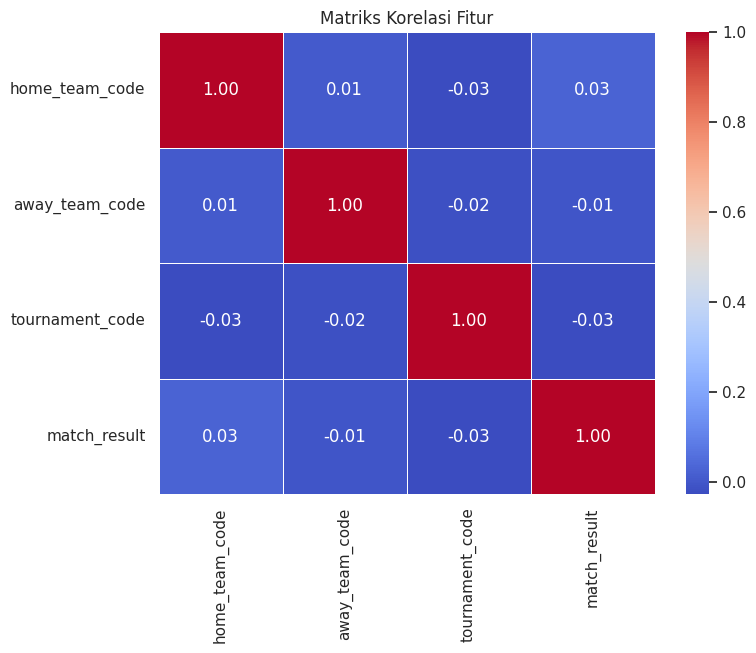

Analisis: Perhatikan kotak 'match_result'. Nilai korelasi menunjukkan seberapa kuat hubungan fitur terhadap hasil.


In [15]:


plt.figure(figsize=(8, 6))

# Menghitung korelasi antar kolom numerik
correlation_matrix = final_df.corr()

# Visualisasi Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriks Korelasi Fitur')
plt.show()

print("Analisis: Perhatikan kotak 'match_result'. Nilai korelasi menunjukkan seberapa kuat hubungan fitur terhadap hasil.")

# --- CELL 7: EDA (DISTRIBUSI KELAS) ---

/tmp/ipython-input-414078223.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='match_result', data=final_df, palette='viridis')


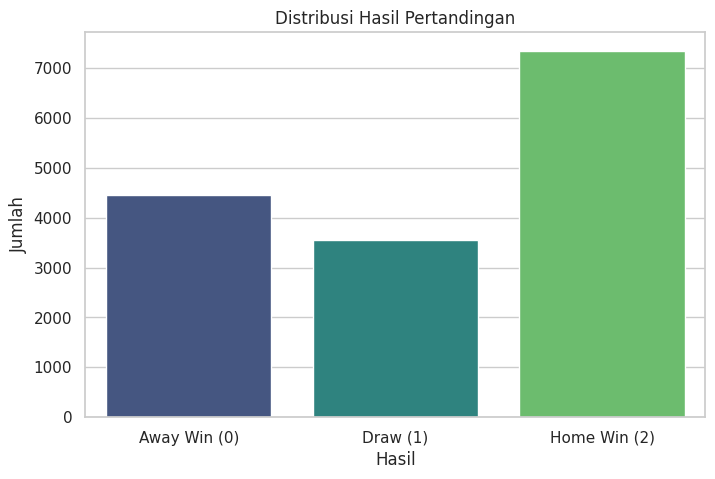

Insight: Jika grafik 'Home Win' paling tinggi, berarti faktor Tuan Rumah sangat berpengaruh.


In [10]:


plt.figure(figsize=(8, 5))
sns.countplot(x='match_result', data=final_df, palette='viridis')

plt.title('Distribusi Hasil Pertandingan')
plt.xticks([0, 1, 2], ['Away Win (0)', 'Draw (1)', 'Home Win (2)'])
plt.xlabel('Hasil')
plt.ylabel('Jumlah')
plt.show()

print("Insight: Jika grafik 'Home Win' paling tinggi, berarti faktor Tuan Rumah sangat berpengaruh.")

# --- CELL 8: SPLIT DATA ---

In [16]:
# --- CELL 8: SPLIT DATA ---

# Definisi X (Fitur) dan y (Target)
X = final_df[['home_team_code', 'away_team_code', 'tournament_code']]
y = final_df['match_result']

# Split 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Training : {len(X_train)} baris")
print(f"Data Testing  : {len(X_test)} baris")

Data Training : 12289 baris
Data Testing  : 3073 baris


# --- CELL 9: MODELING ---

In [17]:
# --- CELL 9: MODELING ---

# Membuat model Random Forest dengan 100 pohon
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

print("Sedang melatih model... ")
rf_model.fit(X_train, y_train)

print("Model Random Forest BERHASIL dilatih")

Sedang melatih model... 
Model Random Forest BERHASIL dilatih


# --- CELL 10: EVALUASI MODEL ---

AKURASI MODEL: 45.88%

--- Laporan Klasifikasi ---
              precision    recall  f1-score   support

    Away Win       0.39      0.39      0.39       853
        Draw       0.23      0.17      0.20       716
    Home Win       0.57      0.63      0.60      1504

    accuracy                           0.46      3073
   macro avg       0.40      0.40      0.40      3073
weighted avg       0.44      0.46      0.45      3073



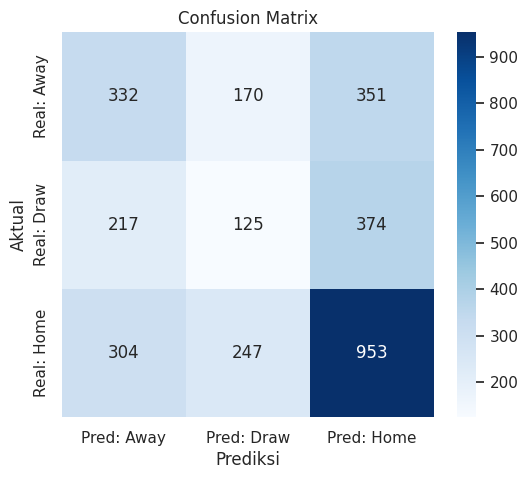

In [13]:
# --- CELL 10: EVALUASI MODEL ---

# Prediksi Data Test
y_pred = rf_model.predict(X_test)

# 1. Akurasi
acc = accuracy_score(y_test, y_pred)
print(f"AKURASI MODEL: {acc * 100:.2f}%\n")

# 2. Classification Report
print("--- Laporan Klasifikasi ---")
print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))

# 3. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Away', 'Pred: Draw', 'Pred: Home'],
            yticklabels=['Real: Away', 'Real: Draw', 'Real: Home'])
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

# --- CELL 11: SIMPAN MODEL ---

In [14]:
# --- CELL 11: SIMPAN MODEL ---

joblib.dump(rf_model, 'model_prediksi_bola_rf.pkl')
print("Model berhasil disimpan sebagai 'model_prediksi_bola_rf.pkl'")

Model berhasil disimpan sebagai 'model_prediksi_bola_rf.pkl'


# --- Kesimpulan ---

Berdasarkan penelitian dan eksperimen yang telah dilakukan menggunakan algoritma Random Forest untuk memprediksi hasil pertandingan sepak bola internasional, dapat ditarik beberapa kesimpulan sebagai berikut:

Kinerja Model: Model berhasil dibangun dan menghasilkan tingkat akurasi sebesar 45.88% pada data uji. Dalam konteks klasifikasi tiga kelas (Tuan Rumah Menang, Seri, Tamu Menang), angka ini menunjukkan peningkatan performa yang signifikan dibandingkan dengan tebakan acak (random guessing) yang hanya memiliki probabilitas kebenaran 33.3%. Hal ini membuktikan bahwa terdapat pola historis dalam data pertandingan yang dapat dipelajari oleh mesin.

Faktor Dominan (Home Advantage): Hasil analisis data (EDA) dan evaluasi model menunjukkan bahwa faktor "Tuan Rumah" (Home Team) memiliki pengaruh yang sangat besar terhadap hasil pertandingan. Model cenderung lebih akurat dalam memprediksi kemenangan tuan rumah dibandingkan hasil seri atau kemenangan tim tamu, mengonfirmasi fenomena Home Advantage dalam sepak bola internasional.

Kendala Prediksi Hasil Seri: Model mengalami kesulitan terbesar dalam memprediksi hasil Seri (Draw), yang terlihat dari nilai Recall dan Precision yang rendah untuk kelas tersebut. Hasil seri seringkali dipengaruhi oleh faktor-faktor situasional di lapangan yang tidak tercatat dalam dataset historis sederhana, menjadikannya pola yang paling sulit dideteksi.